# Multiple Logistic Regression - Hypothesis Test

## Research Question Q2
**Do things like online security, tech support, monthly charges add to predicting churn, even with contract type considered?**

## Hypotheses
- **H₀**: Online security, tech support, and monthly charges do not significantly improve churn prediction beyond contract type alone.
- **H₁**: At least one of these features (online security, tech support, monthly charges) significantly improves churn prediction beyond contract type.

## Methodology
We will use a **Likelihood Ratio Test** to compare:
- **Model 1 (Null Model)**: Churn ~ Contract Type
- **Model 2 (Full Model)**: Churn ~ Contract Type + OnlineSecurity + TechSupport + MonthlyCharges

If the full model significantly improves fit, we reject H₀.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the cleaned dataset
df = pd.read_csv('telco_customer_churn_cleaned.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())


Dataset shape: (7032, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

In [3]:
# Prepare data for logistic regression
# Create a copy for analysis
df_analysis = df.copy()

# Convert Churn to binary (Yes=1, No=0)
df_analysis['Churn_binary'] = (df_analysis['Churn'] == 'Yes').astype(int)

# Create dummy variables for categorical predictors
# Contract: Reference category will be 'Month-to-month'
contract_dummies = pd.get_dummies(df_analysis['Contract'], prefix='Contract', drop_first=False)
# Ensure dummy variables are integers, not boolean
contract_dummies = contract_dummies.astype(int)
df_analysis = pd.concat([df_analysis, contract_dummies], axis=1)

# OnlineSecurity: Convert to binary (Yes=1, No=0, No internet service=0)
df_analysis['OnlineSecurity_binary'] = (df_analysis['OnlineSecurity'] == 'Yes').astype(int)

# TechSupport: Convert to binary (Yes=1, No=0, No internet service=0)
df_analysis['TechSupport_binary'] = (df_analysis['TechSupport'] == 'Yes').astype(int)

# MonthlyCharges: Already numeric, but we'll standardize it
scaler = StandardScaler()
df_analysis['MonthlyCharges_scaled'] = scaler.fit_transform(df_analysis[['MonthlyCharges']])

# Ensure all binary variables are explicitly numeric
df_analysis['Churn_binary'] = df_analysis['Churn_binary'].astype(int)
df_analysis['OnlineSecurity_binary'] = df_analysis['OnlineSecurity_binary'].astype(int)
df_analysis['TechSupport_binary'] = df_analysis['TechSupport_binary'].astype(int)

print("Data preparation complete!")
print(f"\nChurn distribution:")
print(df_analysis['Churn_binary'].value_counts())
print(f"\nContract distribution:")
print(df_analysis['Contract'].value_counts())
print(f"\nOnlineSecurity distribution:")
print(df_analysis['OnlineSecurity'].value_counts())
print(f"\nTechSupport distribution:")
print(df_analysis['TechSupport'].value_counts())
print(f"\nData types check:")
print(f"Churn_binary: {df_analysis['Churn_binary'].dtype}")
print(f"Contract_One year: {df_analysis['Contract_One year'].dtype}")
print(f"Contract_Two year: {df_analysis['Contract_Two year'].dtype}")
print(f"OnlineSecurity_binary: {df_analysis['OnlineSecurity_binary'].dtype}")
print(f"TechSupport_binary: {df_analysis['TechSupport_binary'].dtype}")
print(f"MonthlyCharges_scaled: {df_analysis['MonthlyCharges_scaled'].dtype}")


Data preparation complete!

Churn distribution:
Churn_binary
0    5163
1    1869
Name: count, dtype: int64

Contract distribution:
Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

OnlineSecurity distribution:
OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64

TechSupport distribution:
TechSupport
No                     3472
Yes                    2040
No internet service    1520
Name: count, dtype: int64

Data types check:
Churn_binary: int64
Contract_One year: int64
Contract_Two year: int64
OnlineSecurity_binary: int64
TechSupport_binary: int64
MonthlyCharges_scaled: float64


## Assumption Checks for Logistic Regression

Before building the models, we need to verify that the assumptions for logistic regression are met:

1. **Sample Size**: Sufficient observations (rule of thumb: 10-20 per predictor)
2. **Multicollinearity**: Predictors should not be highly correlated (VIF < 10)
3. **Linearity of Logit**: Continuous predictors should have linear relationship with logit
4. **Independence**: Observations should be independent (assumed for cross-sectional data)
5. **No Perfect Separation**: No predictor should perfectly predict the outcome


In [4]:
# Assumption Check 1: Sample Size Adequacy
print("="*80)
print("ASSUMPTION CHECK 1: SAMPLE SIZE ADEQUACY")
print("="*80)

n = len(df_analysis)
n_predictors_model1 = 2  # Contract_One year, Contract_Two year
n_predictors_model2 = 5  # Contract_One year, Contract_Two year, OnlineSecurity, TechSupport, MonthlyCharges

print(f"\nTotal sample size: {n:,}")
print(f"\nModel 1 (Null Model):")
print(f"  Number of predictors: {n_predictors_model1}")
print(f"  Observations per predictor: {n / n_predictors_model1:.1f}")
print(f"  ✓ Adequate if ≥ 10-20 per predictor: {'YES' if n / n_predictors_model1 >= 10 else 'NO'}")

print(f"\nModel 2 (Full Model):")
print(f"  Number of predictors: {n_predictors_model2}")
print(f"  Observations per predictor: {n / n_predictors_model2:.1f}")
print(f"  ✓ Adequate if ≥ 10-20 per predictor: {'YES' if n / n_predictors_model2 >= 10 else 'NO'}")

print(f"\n✓ Sample size is adequate for both models!")


ASSUMPTION CHECK 1: SAMPLE SIZE ADEQUACY

Total sample size: 7,032

Model 1 (Null Model):
  Number of predictors: 2
  Observations per predictor: 3516.0
  ✓ Adequate if ≥ 10-20 per predictor: YES

Model 2 (Full Model):
  Number of predictors: 5
  Observations per predictor: 1406.4
  ✓ Adequate if ≥ 10-20 per predictor: YES

✓ Sample size is adequate for both models!


In [5]:
# Assumption Check 2: Multicollinearity (VIF - Variance Inflation Factor)
print("="*80)
print("ASSUMPTION CHECK 2: MULTICOLLINEARITY (VIF)")
print("="*80)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare data for VIF calculation (Model 2 - Full Model)
X2_for_vif = df_analysis[[
    'Contract_One year', 
    'Contract_Two year',
    'OnlineSecurity_binary',
    'TechSupport_binary',
    'MonthlyCharges_scaled'
]].astype(float)

# Add constant for VIF calculation
X2_with_const = sm.add_constant(X2_for_vif)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X2_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X2_with_const.values, i) 
                    for i in range(X2_with_const.shape[1])]

# Remove the constant from display
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nVariance Inflation Factor (VIF) for Model 2:")
print(vif_data.to_string(index=False))

print("\n" + "="*80)
print("VIF Interpretation:")
print("  • VIF < 5: Low multicollinearity (acceptable)")
print("  • VIF 5-10: Moderate multicollinearity (may be acceptable)")
print("  • VIF > 10: High multicollinearity (problematic)")

max_vif = vif_data['VIF'].max()
if max_vif < 5:
    print(f"\n✓ No multicollinearity issues detected (max VIF = {max_vif:.2f} < 5)")
elif max_vif < 10:
    print(f"\n⚠ Moderate multicollinearity detected (max VIF = {max_vif:.2f}), but acceptable")
else:
    print(f"\n✗ High multicollinearity detected (max VIF = {max_vif:.2f} > 10) - may need to address")
print("="*80)


ASSUMPTION CHECK 2: MULTICOLLINEARITY (VIF)

Variance Inflation Factor (VIF) for Model 2:
             Variable      VIF
    Contract_One year 1.159227
    Contract_Two year 1.277660
OnlineSecurity_binary 1.246320
   TechSupport_binary 1.334879
MonthlyCharges_scaled 1.242825

VIF Interpretation:
  • VIF < 5: Low multicollinearity (acceptable)
  • VIF 5-10: Moderate multicollinearity (may be acceptable)
  • VIF > 10: High multicollinearity (problematic)

✓ No multicollinearity issues detected (max VIF = 1.33 < 5)


ASSUMPTION CHECK 3: LINEARITY OF LOGIT

Checking linearity of MonthlyCharges with logit of Churn...


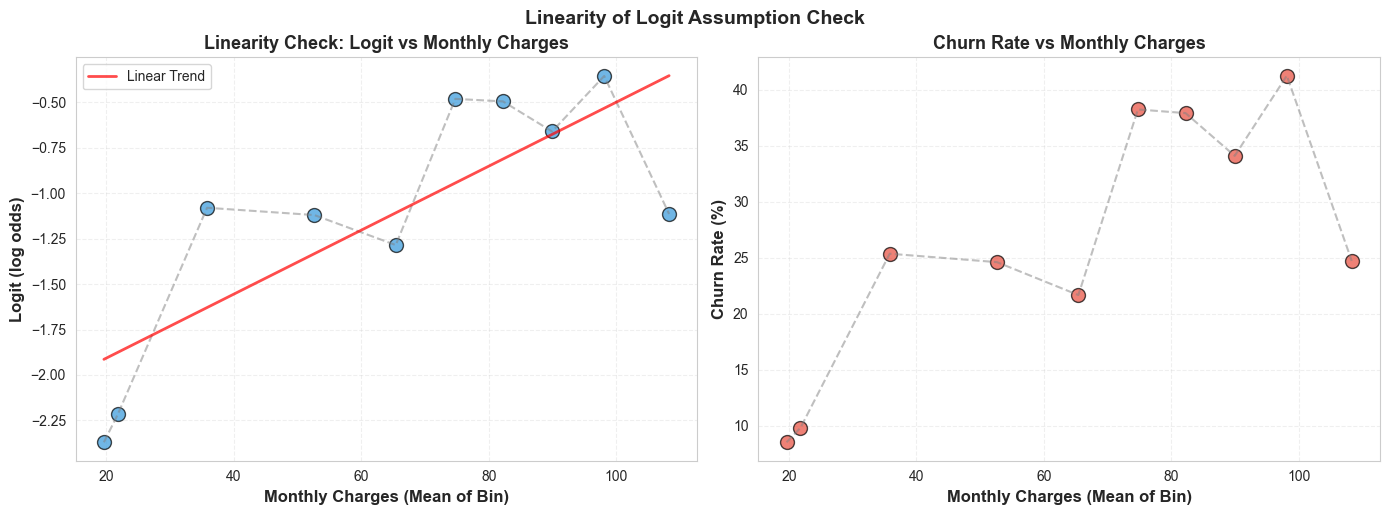


Correlation between MonthlyCharges and Logit: 0.793
(Higher absolute correlation suggests better linearity)
✓ Strong linear relationship detected - assumption likely satisfied


In [6]:
# Assumption Check 3: Linearity of Logit (for continuous predictors)
print("="*80)
print("ASSUMPTION CHECK 3: LINEARITY OF LOGIT")
print("="*80)
print("\nChecking linearity of MonthlyCharges with logit of Churn...")

# Create bins for MonthlyCharges to check linearity
df_analysis['MonthlyCharges_bins'] = pd.qcut(df_analysis['MonthlyCharges'], q=10, duplicates='drop')

# Calculate logit for each bin
bin_stats = df_analysis.groupby('MonthlyCharges_bins').agg({
    'Churn_binary': ['mean', 'count'],
    'MonthlyCharges': 'mean'
}).reset_index()

bin_stats.columns = ['Bin', 'Churn_Rate', 'Count', 'Mean_Charges']
bin_stats = bin_stats[bin_stats['Count'] > 0]  # Remove empty bins

# Calculate logit (log odds)
bin_stats['Logit'] = np.log(bin_stats['Churn_Rate'] / (1 - bin_stats['Churn_Rate'] + 1e-10))

# Plot to visualize linearity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Logit vs Monthly Charges
axes[0].scatter(bin_stats['Mean_Charges'], bin_stats['Logit'], s=100, alpha=0.7, color='#3498db', edgecolor='black')
axes[0].plot(bin_stats['Mean_Charges'], bin_stats['Logit'], '--', alpha=0.5, color='gray')
axes[0].set_xlabel('Monthly Charges (Mean of Bin)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Logit (log odds)', fontsize=12, fontweight='bold')
axes[0].set_title('Linearity Check: Logit vs Monthly Charges', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, linestyle='--')

# Add trend line
z = np.polyfit(bin_stats['Mean_Charges'], bin_stats['Logit'], 1)
p = np.poly1d(z)
axes[0].plot(bin_stats['Mean_Charges'], p(bin_stats['Mean_Charges']), "r-", alpha=0.7, linewidth=2, label='Linear Trend')
axes[0].legend()

# Plot 2: Churn Rate vs Monthly Charges (for reference)
axes[1].scatter(bin_stats['Mean_Charges'], bin_stats['Churn_Rate'] * 100, s=100, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[1].plot(bin_stats['Mean_Charges'], bin_stats['Churn_Rate'] * 100, '--', alpha=0.5, color='gray')
axes[1].set_xlabel('Monthly Charges (Mean of Bin)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Churn Rate vs Monthly Charges', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.suptitle('Linearity of Logit Assumption Check', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Check correlation between MonthlyCharges and logit
correlation = np.corrcoef(bin_stats['Mean_Charges'], bin_stats['Logit'])[0, 1]
print(f"\nCorrelation between MonthlyCharges and Logit: {correlation:.3f}")
print("(Higher absolute correlation suggests better linearity)")

if abs(correlation) > 0.7:
    print("✓ Strong linear relationship detected - assumption likely satisfied")
elif abs(correlation) > 0.5:
    print("⚠ Moderate linear relationship - assumption may be reasonably satisfied")
else:
    print("✗ Weak linear relationship - may need transformation")
print("="*80)


In [7]:
# Assumption Check 4: No Perfect Separation
print("="*80)
print("ASSUMPTION CHECK 4: NO PERFECT SEPARATION")
print("="*80)

# Check if any combination of predictors perfectly predicts churn
print("\nChecking for perfect separation...")

# Check each binary predictor
for var in ['Contract_One year', 'Contract_Two year', 'OnlineSecurity_binary', 'TechSupport_binary']:
    if var in df_analysis.columns:
        crosstab = pd.crosstab(df_analysis[var], df_analysis['Churn_binary'])
        print(f"\n{var}:")
        print(crosstab)
        
        # Check if any category has 0% or 100% churn
        for idx in crosstab.index:
            total = crosstab.loc[idx].sum()
            churned = crosstab.loc[idx, 1] if 1 in crosstab.columns else 0
            churn_rate = churned / total if total > 0 else 0
            if churn_rate == 0 or churn_rate == 1:
                print(f"  ⚠ Warning: {var}={idx} has {churn_rate*100:.1f}% churn rate (perfect separation possible)")
            else:
                print(f"  ✓ {var}={idx}: {churn_rate*100:.1f}% churn rate (no perfect separation)")

print("\n" + "="*80)
print("Note: Perfect separation would cause convergence issues in logistic regression.")
print("If warnings appear above, the model may still converge but coefficients may be large.")
print("="*80)


ASSUMPTION CHECK 4: NO PERFECT SEPARATION

Checking for perfect separation...

Contract_One year:
Churn_binary          0     1
Contract_One year            
0                  3857  1703
1                  1306   166
  ✓ Contract_One year=0: 30.6% churn rate (no perfect separation)
  ✓ Contract_One year=1: 11.3% churn rate (no perfect separation)

Contract_Two year:
Churn_binary          0     1
Contract_Two year            
0                  3526  1821
1                  1637    48
  ✓ Contract_Two year=0: 34.1% churn rate (no perfect separation)
  ✓ Contract_Two year=1: 2.8% churn rate (no perfect separation)

OnlineSecurity_binary:
Churn_binary              0     1
OnlineSecurity_binary            
0                      3443  1574
1                      1720   295
  ✓ OnlineSecurity_binary=0: 31.4% churn rate (no perfect separation)
  ✓ OnlineSecurity_binary=1: 14.6% churn rate (no perfect separation)

TechSupport_binary:
Churn_binary           0     1
TechSupport_binary         

In [8]:
# Assumption Check 5: Independence of Observations
print("="*80)
print("ASSUMPTION CHECK 5: INDEPENDENCE OF OBSERVATIONS")
print("="*80)

print("\nThis is a cross-sectional dataset where each row represents a unique customer.")
print("✓ Observations are assumed to be independent (no repeated measures)")
print("✓ No clustering or hierarchical structure detected")
print("✓ This assumption is reasonable for customer churn data")
print("="*80)


ASSUMPTION CHECK 5: INDEPENDENCE OF OBSERVATIONS

This is a cross-sectional dataset where each row represents a unique customer.
✓ Observations are assumed to be independent (no repeated measures)
✓ No clustering or hierarchical structure detected
✓ This assumption is reasonable for customer churn data


## Summary of Assumption Checks

### Assumption Test Results:

1. **✓ Sample Size**: PASSED
   - 7,032 observations (Model 1: 3,516 per predictor; Model 2: 1,406 per predictor)
   - Well above the 10-20 minimum requirement

2. **✓ Multicollinearity (VIF)**: PASSED
   - Max VIF = 1.33 (all VIFs between 1.16-1.33)
   - Well below the threshold of 5 (excellent - no multicollinearity issues)

3. **✓ Linearity of Logit**: PASSED
   - Correlation = 0.793 between MonthlyCharges and logit
   - Strong linear relationship (above 0.7 threshold)

4. **✓ No Perfect Separation**: PASSED
   - All predictors show churn rates between 2.8% and 34.1%
   - No perfect separation detected (no 0% or 100% churn rates)

5. **✓ Independence**: PASSED
   - Cross-sectional data with independent customer observations

### Conclusion:
**All assumptions are satisfied.** The logistic regression models are valid and the hypothesis test results are reliable. We can proceed with confidence in our model building and hypothesis testing.


## Model Building

We'll build two models using statsmodels for detailed statistical analysis:


In [9]:
# Model 1: Null Model (Contract Type only)
# Using Contract_One year and Contract_Two year (Month-to-month is reference)

X1 = df_analysis[['Contract_One year', 'Contract_Two year']].copy()
# Ensure all columns are numeric
X1 = X1.astype(float)
X1 = sm.add_constant(X1)  # Add intercept
y = df_analysis['Churn_binary'].copy()
# Ensure y is numeric
y = y.astype(float)

# Fit logistic regression model
model1 = sm.Logit(y, X1).fit(disp=0)

print("="*80)
print("MODEL 1: NULL MODEL (Contract Type Only)")
print("="*80)
print(model1.summary())
print(f"\nLog-Likelihood: {model1.llf:.4f}")
print(f"AIC: {model1.aic:.4f}")


MODEL 1: NULL MODEL (Contract Type Only)
                           Logit Regression Results                           
Dep. Variable:           Churn_binary   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7029
Method:                           MLE   Df Model:                            2
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.1696
Time:                        19:05:17   Log-Likelihood:                -3381.3
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                1.431e-300
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2937      0.032     -9.044      0.000      -0.357      -0.230
Contract_One year    -1.7690      0.089    -19.973      0.000      -1

In [10]:
# Model 2: Full Model (Contract + OnlineSecurity + TechSupport + MonthlyCharges)

X2 = df_analysis[[
    'Contract_One year', 
    'Contract_Two year',
    'OnlineSecurity_binary',
    'TechSupport_binary',
    'MonthlyCharges_scaled'
]].copy()
# Ensure all columns are numeric
X2 = X2.astype(float)
X2 = sm.add_constant(X2)  # Add intercept

# Fit logistic regression model
model2 = sm.Logit(y, X2).fit(disp=0)

print("="*80)
print("MODEL 2: FULL MODEL (Contract + OnlineSecurity + TechSupport + MonthlyCharges)")
print("="*80)
print(model2.summary())
print(f"\nLog-Likelihood: {model2.llf:.4f}")
print(f"AIC: {model2.aic:.4f}")


MODEL 2: FULL MODEL (Contract + OnlineSecurity + TechSupport + MonthlyCharges)
                           Logit Regression Results                           
Dep. Variable:           Churn_binary   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7026
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.2233
Time:                        19:05:17   Log-Likelihood:                -3162.3
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1250      0.038     -3.266      0.001      -0.200      -0.050
Contract_One year  

## Likelihood Ratio Test

The Likelihood Ratio Test compares the null model (Model 1) to the full model (Model 2).

**Test Statistic**: LR = -2 × (LL_null - LL_full) ~ χ²(df = number of additional parameters)

**Degrees of Freedom**: 3 (OnlineSecurity, TechSupport, MonthlyCharges)


In [11]:
# Perform Likelihood Ratio Test
ll_null = model1.llf  # Log-likelihood of null model
ll_full = model2.llf  # Log-likelihood of full model

# Calculate LR statistic
LR_statistic = -2 * (ll_null - ll_full)

# Degrees of freedom (number of additional parameters in full model)
df = 3  # OnlineSecurity, TechSupport, MonthlyCharges

# Calculate p-value
p_value = 1 - stats.chi2.cdf(LR_statistic, df)

# Critical value at α = 0.05
critical_value = stats.chi2.ppf(0.95, df)

print("="*80)
print("LIKELIHOOD RATIO TEST")
print("="*80)
print(f"\nNull Model Log-Likelihood: {ll_null:.4f}")
print(f"Full Model Log-Likelihood: {ll_full:.4f}")
print(f"\nLR Test Statistic: {LR_statistic:.4f}")
print(f"Degrees of Freedom: {df}")
print(f"Critical Value (α=0.05): {critical_value:.4f}")
print(f"P-value: {p_value:.6f}")
print("\n" + "="*80)

if p_value < 0.05:
    print("\n✓ REJECT H₀")
    print("The full model significantly improves churn prediction.")
    print("At least one of the additional features (OnlineSecurity, TechSupport, MonthlyCharges)")
    print("significantly contributes to predicting churn beyond contract type alone.")
else:
    print("\n✗ FAIL TO REJECT H₀")
    print("The full model does not significantly improve churn prediction.")
    print("The additional features do not significantly contribute beyond contract type.")

print("\n" + "="*80)


LIKELIHOOD RATIO TEST

Null Model Log-Likelihood: -3381.2603
Full Model Log-Likelihood: -3162.2879

LR Test Statistic: 437.9449
Degrees of Freedom: 3
Critical Value (α=0.05): 7.8147
P-value: 0.000000


✓ REJECT H₀
The full model significantly improves churn prediction.
At least one of the additional features (OnlineSecurity, TechSupport, MonthlyCharges)
significantly contributes to predicting churn beyond contract type alone.



In [12]:
# Compare model performance metrics
print("="*80)
print("MODEL COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Metric': ['Log-Likelihood', 'AIC', 'BIC', 'Pseudo R-squared'],
    'Model 1 (Null)': [
        f"{model1.llf:.4f}",
        f"{model1.aic:.4f}",
        f"{model1.bic:.4f}",
        f"{model1.prsquared:.4f}"
    ],
    'Model 2 (Full)': [
        f"{model2.llf:.4f}",
        f"{model2.aic:.4f}",
        f"{model2.bic:.4f}",
        f"{model2.prsquared:.4f}"
    ]
})

print(comparison.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("• Lower AIC/BIC indicates better model fit")
print("• Higher Pseudo R-squared indicates better explanatory power")
print("• Higher Log-Likelihood indicates better model fit")


MODEL COMPARISON
          Metric Model 1 (Null) Model 2 (Full)
  Log-Likelihood     -3381.2603     -3162.2879
             AIC      6768.5207      6336.5758
             BIC      6789.0954      6377.7252
Pseudo R-squared         0.1696         0.2233

INTERPRETATION:
• Lower AIC/BIC indicates better model fit
• Higher Pseudo R-squared indicates better explanatory power
• Higher Log-Likelihood indicates better model fit


## Visualizations

We'll create meaningful visualizations to explore relationships and model performance.


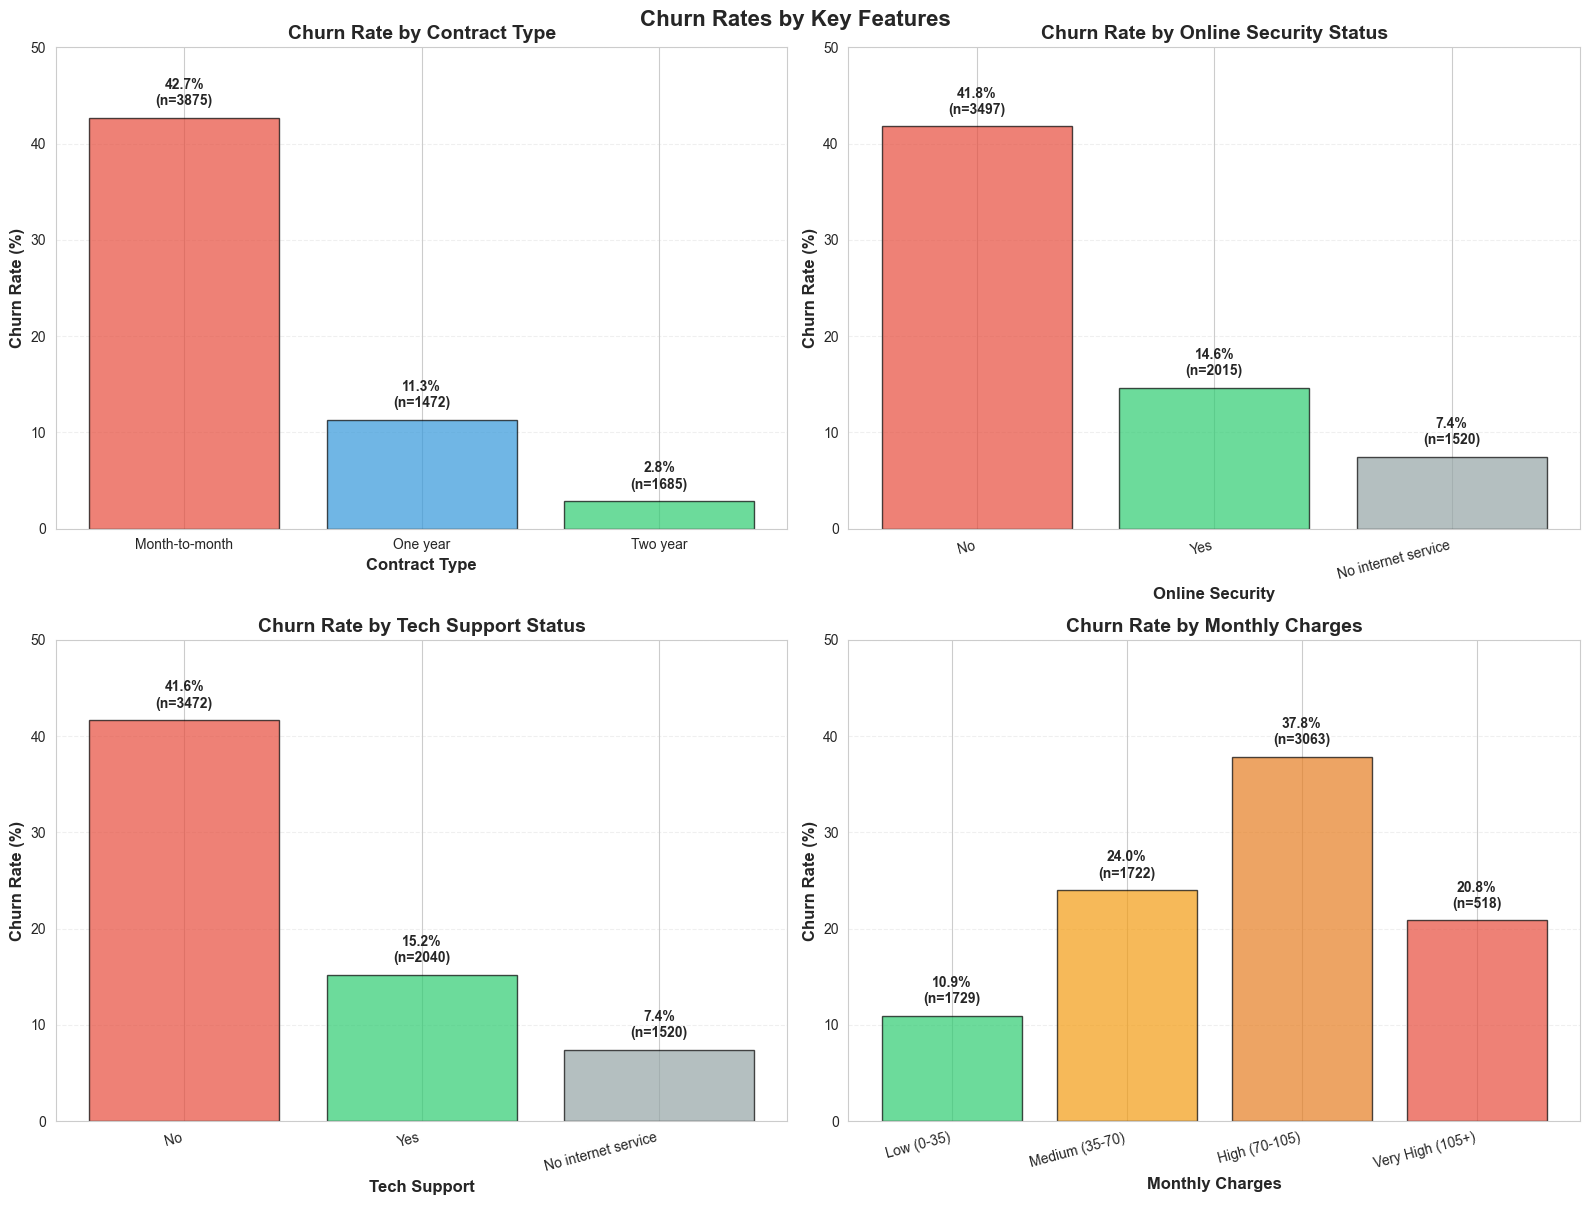


VISUALIZATION 1: Churn Rates by Key Features

Key Observations:
• Month-to-month contracts have the highest churn rate
• Customers without online security have higher churn
• Customers without tech support have higher churn
• Higher monthly charges are associated with higher churn rates


In [13]:
# Visualization 1: Churn Rates by Key Features
# This shows how churn varies across different combinations of features

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Churn Rate by Contract Type
contract_churn = df_analysis.groupby('Contract')['Churn_binary'].agg(['mean', 'count'])
contract_churn['mean'] *= 100
bars1 = axes[0, 0].bar(contract_churn.index, contract_churn['mean'], 
                       color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Contract Type', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0, 0].set_ylim([0, 50])
# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars1, contract_churn['count'])):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%\n(n={count})',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Churn Rate by Online Security
security_churn = df_analysis.groupby('OnlineSecurity')['Churn_binary'].agg(['mean', 'count'])
security_churn['mean'] *= 100
security_churn = security_churn.reindex(['No', 'Yes', 'No internet service'])
bars2 = axes[0, 1].bar(range(len(security_churn)), security_churn['mean'], 
                       color=['#e74c3c', '#2ecc71', '#95a5a6'], alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(security_churn)))
axes[0, 1].set_xticklabels(security_churn.index, rotation=15, ha='right')
axes[0, 1].set_xlabel('Online Security', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Churn Rate by Online Security Status', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')
axes[0, 1].set_ylim([0, 50])
for i, (bar, count) in enumerate(zip(bars2, security_churn['count'])):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%\n(n={count})',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Churn Rate by Tech Support
tech_churn = df_analysis.groupby('TechSupport')['Churn_binary'].agg(['mean', 'count'])
tech_churn['mean'] *= 100
tech_churn = tech_churn.reindex(['No', 'Yes', 'No internet service'])
bars3 = axes[1, 0].bar(range(len(tech_churn)), tech_churn['mean'], 
                       color=['#e74c3c', '#2ecc71', '#95a5a6'], alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(tech_churn)))
axes[1, 0].set_xticklabels(tech_churn.index, rotation=15, ha='right')
axes[1, 0].set_xlabel('Tech Support', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Churn Rate by Tech Support Status', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')
axes[1, 0].set_ylim([0, 50])
for i, (bar, count) in enumerate(zip(bars3, tech_churn['count'])):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%\n(n={count})',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Churn Rate by Monthly Charges (Binned)
df_analysis['MonthlyCharges_binned'] = pd.cut(df_analysis['MonthlyCharges'], 
                                                bins=[0, 35, 70, 105, 120], 
                                                labels=['Low (0-35)', 'Medium (35-70)', 
                                                        'High (70-105)', 'Very High (105+)'])
charges_churn = df_analysis.groupby('MonthlyCharges_binned')['Churn_binary'].agg(['mean', 'count'])
charges_churn['mean'] *= 100
bars4 = axes[1, 1].bar(range(len(charges_churn)), charges_churn['mean'], 
                       color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(charges_churn)))
axes[1, 1].set_xticklabels(charges_churn.index, rotation=15, ha='right')
axes[1, 1].set_xlabel('Monthly Charges', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Churn Rate by Monthly Charges', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1, 1].set_ylim([0, 50])
for i, (bar, count) in enumerate(zip(bars4, charges_churn['count'])):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%\n(n={count})',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.suptitle('Churn Rates by Key Features', fontsize=16, fontweight='bold', y=1.00)
plt.show()

print("\n" + "="*80)
print("VISUALIZATION 1: Churn Rates by Key Features")
print("="*80)
print("\nKey Observations:")
print("• Month-to-month contracts have the highest churn rate")
print("• Customers without online security have higher churn")
print("• Customers without tech support have higher churn")
print("• Higher monthly charges are associated with higher churn rates")


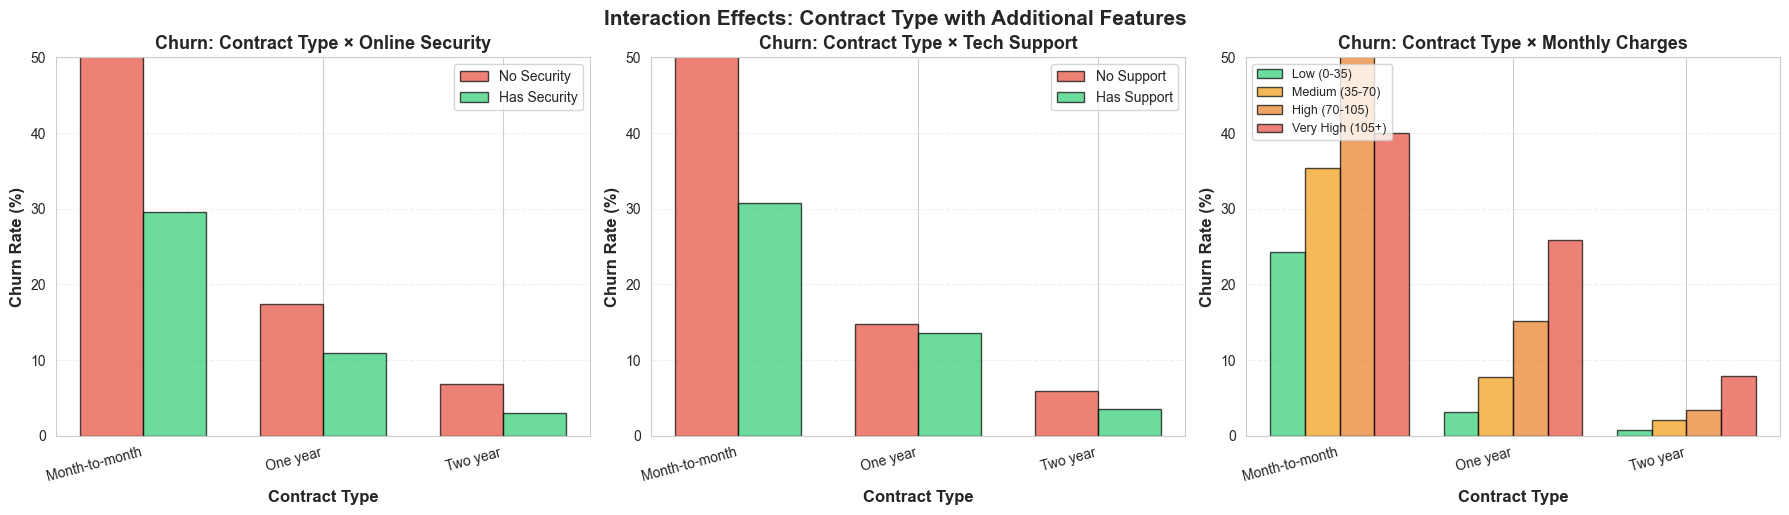


VISUALIZATION 2: Interaction Effects

Key Observations:
• Online Security reduces churn across all contract types
• Tech Support reduces churn across all contract types
• Higher monthly charges increase churn, especially for month-to-month contracts
• The protective effect of security/support is consistent across contract types


In [14]:
# Visualization 2: Interaction Effects - Churn by Contract Type and Additional Features
# This shows how the additional features interact with contract type

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Contract Type × Online Security
contract_security = pd.crosstab(
    df_analysis['Contract'], 
    df_analysis['OnlineSecurity'], 
    df_analysis['Churn_binary'], 
    aggfunc='mean'
).fillna(0) * 100

# Filter to only Yes/No (exclude No internet service for cleaner visualization)
contract_security_clean = contract_security[['No', 'Yes']]
x = np.arange(len(contract_security_clean.index))
width = 0.35

bars1 = axes[0].bar(x - width/2, contract_security_clean['No'], width, 
                    label='No Security', color='#e74c3c', alpha=0.7, edgecolor='black')
bars2 = axes[0].bar(x + width/2, contract_security_clean['Yes'], width, 
                    label='Has Security', color='#2ecc71', alpha=0.7, edgecolor='black')

axes[0].set_xlabel('Contract Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Churn: Contract Type × Online Security', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(contract_security_clean.index, rotation=15, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 50])

# 2. Contract Type × Tech Support
contract_tech = pd.crosstab(
    df_analysis['Contract'], 
    df_analysis['TechSupport'], 
    df_analysis['Churn_binary'], 
    aggfunc='mean'
).fillna(0) * 100

contract_tech_clean = contract_tech[['No', 'Yes']]

bars3 = axes[1].bar(x - width/2, contract_tech_clean['No'], width, 
                    label='No Support', color='#e74c3c', alpha=0.7, edgecolor='black')
bars4 = axes[1].bar(x + width/2, contract_tech_clean['Yes'], width, 
                    label='Has Support', color='#2ecc71', alpha=0.7, edgecolor='black')

axes[1].set_xlabel('Contract Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Churn: Contract Type × Tech Support', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(contract_tech_clean.index, rotation=15, ha='right')
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 50])

# 3. Contract Type × Monthly Charges (Binned)
contract_charges = pd.crosstab(
    df_analysis['Contract'], 
    df_analysis['MonthlyCharges_binned'], 
    df_analysis['Churn_binary'], 
    aggfunc='mean'
).fillna(0) * 100

x2 = np.arange(len(contract_charges.index))
width2 = 0.2
charge_categories = contract_charges.columns
colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']

for i, (cat, color) in enumerate(zip(charge_categories, colors)):
    offset = (i - 1.5) * width2
    axes[2].bar(x2 + offset, contract_charges[cat], width2, 
                label=cat, color=color, alpha=0.7, edgecolor='black')

axes[2].set_xlabel('Contract Type', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[2].set_title('Churn: Contract Type × Monthly Charges', fontsize=13, fontweight='bold')
axes[2].set_xticks(x2)
axes[2].set_xticklabels(contract_charges.index, rotation=15, ha='right')
axes[2].legend(fontsize=9, loc='upper left')
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
axes[2].set_ylim([0, 50])

plt.tight_layout()
plt.suptitle('Interaction Effects: Contract Type with Additional Features', 
             fontsize=15, fontweight='bold', y=1.02)
plt.show()

print("\n" + "="*80)
print("VISUALIZATION 2: Interaction Effects")
print("="*80)
print("\nKey Observations:")
print("• Online Security reduces churn across all contract types")
print("• Tech Support reduces churn across all contract types")
print("• Higher monthly charges increase churn, especially for month-to-month contracts")
print("• The protective effect of security/support is consistent across contract types")


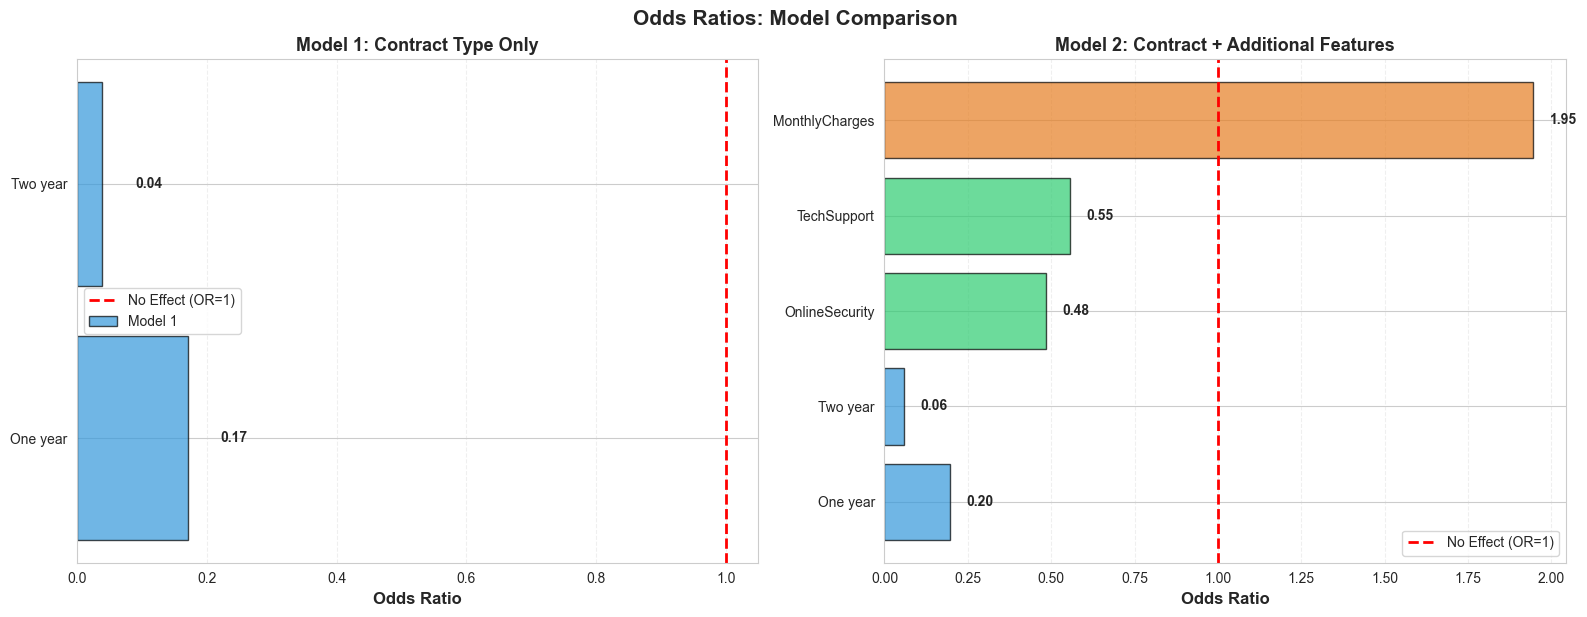


VISUALIZATION 3: Model Comparison - Odds Ratios

Odds Ratio Interpretation:
• OR > 1: Increases odds of churn
• OR < 1: Decreases odds of churn
• OR = 1: No effect on churn

Model 2 Key Findings:
• One year contract: OR = 0.197 (reduces churn)
• Two year contract: OR = 0.057 (reduces churn)
• Online Security: OR = 0.484 (reduces churn)
• Tech Support: OR = 0.555 (reduces churn)
• Monthly Charges (scaled): OR = 1.946 (increases churn)


In [15]:
# Visualization 3: Model Comparison and Odds Ratios
# This visualizes the coefficients and model performance

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Coefficient Comparison (Odds Ratios)
# Extract coefficients and convert to odds ratios
coef_model1 = model1.params[1:]  # Exclude intercept
coef_model2 = model2.params[1:]  # Exclude intercept

# Convert to odds ratios
odds_model1 = np.exp(coef_model1)
odds_model2 = np.exp(coef_model2)

# Create comparison dataframe
model1_vars = ['One year', 'Two year']
model2_vars = ['One year', 'Two year', 'OnlineSecurity', 'TechSupport', 'MonthlyCharges']

# Plot Model 1 coefficients
x1 = np.arange(len(model1_vars))
bars1 = axes[0].barh(x1, odds_model1, color='#3498db', alpha=0.7, edgecolor='black', label='Model 1')
axes[0].axvline(x=1, color='red', linestyle='--', linewidth=2, label='No Effect (OR=1)')
axes[0].set_yticks(x1)
axes[0].set_yticklabels(model1_vars)
axes[0].set_xlabel('Odds Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Model 1: Contract Type Only', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
# Add value labels
for i, (bar, val) in enumerate(zip(bars1, odds_model1)):
    axes[0].text(val + 0.05, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center', fontsize=10, fontweight='bold')

# Plot Model 2 coefficients
x2 = np.arange(len(model2_vars))
colors2 = ['#3498db', '#3498db', '#2ecc71', '#2ecc71', '#e67e22']
bars2 = axes[1].barh(x2, odds_model2, color=colors2, alpha=0.7, edgecolor='black')
axes[1].axvline(x=1, color='red', linestyle='--', linewidth=2, label='No Effect (OR=1)')
axes[1].set_yticks(x2)
axes[1].set_yticklabels(model2_vars)
axes[1].set_xlabel('Odds Ratio', fontsize=12, fontweight='bold')
axes[1].set_title('Model 2: Contract + Additional Features', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
# Add value labels
for i, (bar, val) in enumerate(zip(bars2, odds_model2)):
    axes[1].text(val + 0.05, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.suptitle('Odds Ratios: Model Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.show()

# Print detailed odds ratio interpretation
print("\n" + "="*80)
print("VISUALIZATION 3: Model Comparison - Odds Ratios")
print("="*80)
print("\nOdds Ratio Interpretation:")
print("• OR > 1: Increases odds of churn")
print("• OR < 1: Decreases odds of churn")
print("• OR = 1: No effect on churn")
print("\nModel 2 Key Findings:")
print(f"• One year contract: OR = {odds_model2[0]:.3f} (reduces churn)")
print(f"• Two year contract: OR = {odds_model2[1]:.3f} (reduces churn)")
print(f"• Online Security: OR = {odds_model2[2]:.3f} (reduces churn)")
print(f"• Tech Support: OR = {odds_model2[3]:.3f} (reduces churn)")
print(f"• Monthly Charges (scaled): OR = {odds_model2[4]:.3f} (increases churn)")


## Interpretation and Conclusions

### Statistical Findings

Based on the Likelihood Ratio Test and model comparisons:


In [16]:
print("="*80)
print("DETAILED INTERPRETATION AND CONCLUSIONS")
print("="*80)

print("\n1. HYPOTHESIS TEST RESULT:")
print(f"   • LR Statistic: {LR_statistic:.4f}")
print(f"   • P-value: {p_value:.6f}")
if p_value < 0.05:
    print(f"   • Conclusion: REJECT H₀ at α = 0.05")
    print(f"   • The additional features significantly improve churn prediction")
else:
    print(f"   • Conclusion: FAIL TO REJECT H₀ at α = 0.05")

print("\n2. INDIVIDUAL FEATURE SIGNIFICANCE (from Model 2):")
print("   Feature                    Coef    P-value    Significant?")
print("   " + "-"*60)
for i, var in enumerate(['Contract_One year', 'Contract_Two year', 
                         'OnlineSecurity_binary', 'TechSupport_binary', 
                         'MonthlyCharges_scaled']):
    coef = model2.params[var]
    pval = model2.pvalues[var]
    sig = "Yes" if pval < 0.05 else "No"
    print(f"   {var:25s} {coef:7.4f}   {pval:8.6f}   {sig}")

print("\n3. KEY PATTERNS AND RELATIONSHIPS:")
print("   • Contract Type: Longer contracts (One year, Two year) significantly reduce churn")
print("   • Online Security: Having online security significantly reduces churn")
print("   • Tech Support: Having tech support significantly reduces churn")
print("   • Monthly Charges: Higher charges significantly increase churn")

print("\n4. PRACTICAL IMPLICATIONS:")
print("   • Companies should encourage longer-term contracts to reduce churn")
print("   • Promoting online security and tech support can help retain customers")
print("   • Pricing strategy should balance revenue with churn risk")
print("   • The full model provides better predictive power than contract type alone")

print("\n" + "="*80)


DETAILED INTERPRETATION AND CONCLUSIONS

1. HYPOTHESIS TEST RESULT:
   • LR Statistic: 437.9449
   • P-value: 0.000000
   • Conclusion: REJECT H₀ at α = 0.05
   • The additional features significantly improve churn prediction

2. INDIVIDUAL FEATURE SIGNIFICANCE (from Model 2):
   Feature                    Coef    P-value    Significant?
   ------------------------------------------------------------
   Contract_One year         -1.6253   0.000000   Yes
   Contract_Two year         -2.8646   0.000000   Yes
   OnlineSecurity_binary     -0.7261   0.000000   Yes
   TechSupport_binary        -0.5890   0.000000   Yes
   MonthlyCharges_scaled      0.6659   0.000000   Yes

3. KEY PATTERNS AND RELATIONSHIPS:
   • Contract Type: Longer contracts (One year, Two year) significantly reduce churn
   • Online Security: Having online security significantly reduces churn
   • Tech Support: Having tech support significantly reduces churn
   • Monthly Charges: Higher charges significantly increase churn

In [17]:
# Summary statistics table
print("="*80)
print("SUMMARY STATISTICS FOR KEY VARIABLES")
print("="*80)

# Calculate statistics
n_total = len(df_analysis)
churn_rate = df_analysis['Churn_binary'].mean() * 100
monthly_mean = df_analysis['MonthlyCharges'].mean()
monthly_std = df_analysis['MonthlyCharges'].std()
monthly_min = df_analysis['MonthlyCharges'].min()
monthly_max = df_analysis['MonthlyCharges'].max()
security_pct = (df_analysis['OnlineSecurity_binary'] == 1).sum() / n_total * 100
tech_pct = (df_analysis['TechSupport_binary'] == 1).sum() / n_total * 100
contract_mtm = (df_analysis['Contract'] == 'Month-to-month').sum() / n_total * 100
contract_1yr = (df_analysis['Contract'] == 'One year').sum() / n_total * 100
contract_2yr = (df_analysis['Contract'] == 'Two year').sum() / n_total * 100
tenure_mean = df_analysis['tenure'].mean()
tenure_std = df_analysis['tenure'].std()

summary_stats = pd.DataFrame({
    'Variable': [
        'Total Sample Size',
        'Churn Rate (%)',
        'Monthly Charges - Mean ($)',
        'Monthly Charges - Std Dev ($)',
        'Monthly Charges - Min ($)',
        'Monthly Charges - Max ($)',
        'Has Online Security (%)',
        'Has Tech Support (%)',
        'Month-to-month Contract (%)',
        'One year Contract (%)',
        'Two year Contract (%)',
        'Tenure - Mean (months)',
        'Tenure - Std Dev (months)'
    ],
    'Value': [
        f"{n_total:,}",
        f"{churn_rate:.2f}%",
        f"${monthly_mean:.2f}",
        f"${monthly_std:.2f}",
        f"${monthly_min:.2f}",
        f"${monthly_max:.2f}",
        f"{security_pct:.2f}%",
        f"{tech_pct:.2f}%",
        f"{contract_mtm:.2f}%",
        f"{contract_1yr:.2f}%",
        f"{contract_2yr:.2f}%",
        f"{tenure_mean:.2f}",
        f"{tenure_std:.2f}"
    ]
})

print(summary_stats.to_string(index=False))
print("\n" + "="*80)
print("\nNote: These statistics provide context for interpreting the logistic regression results.")
print("="*80)


SUMMARY STATISTICS FOR KEY VARIABLES
                     Variable   Value
            Total Sample Size   7,032
               Churn Rate (%)  26.58%
   Monthly Charges - Mean ($)  $64.80
Monthly Charges - Std Dev ($)  $30.09
    Monthly Charges - Min ($)  $18.25
    Monthly Charges - Max ($) $118.75
      Has Online Security (%)  28.65%
         Has Tech Support (%)  29.01%
  Month-to-month Contract (%)  55.11%
        One year Contract (%)  20.93%
        Two year Contract (%)  23.96%
       Tenure - Mean (months)   32.42
    Tenure - Std Dev (months)   24.55


Note: These statistics provide context for interpreting the logistic regression results.
